# AutoInland Vehicle Insurance Claim Challenge StarterNotebook - Python

This is a simple starter notebook to get started with the AutoInland Vehicle Insurance Claim Challenge on Zindi.

This notebook covers:
- Loading the data
- Simple EDA and an example of feature enginnering
- Data preprocessing and data wrangling
- Creating a simple model
- Making a submission
- Some tips for improving your score

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### Read files

In [2]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')

### Some basic EDA

In [3]:
# Preview the first five rows of the train set
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [4]:
# Preview the first five rows of the test set
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [5]:
# Preview the first five rows of the sample submission file
ss.head()

,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0


In [6]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (12079, 14)
The shape of the test set is: (1202, 13)


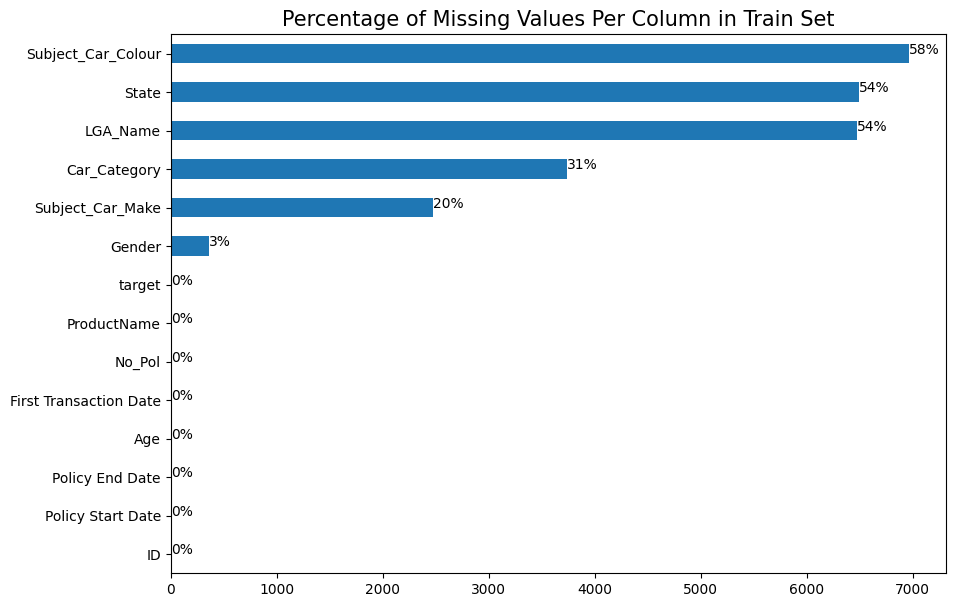

In [7]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

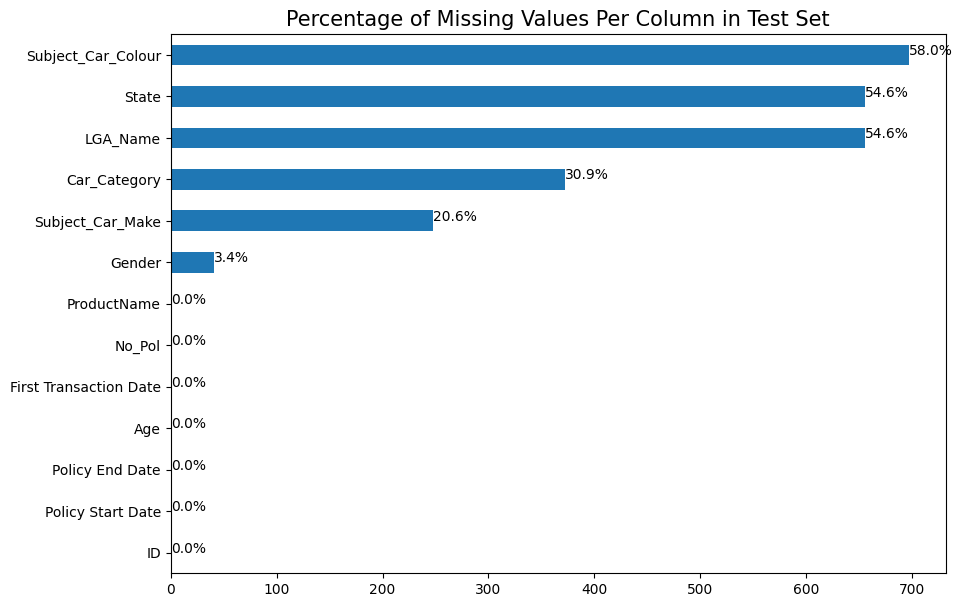

In [8]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Combine train and test set for easy preprocessing 

In [9]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (13281, 14)


In [10]:
# Preview the last five rows of the combined dataframe
all_data.tail()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
13276,ID_ZTTHC5X,2010-12-05,2011-12-04,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,Victoria Island,Lagos,Car Classic,NaN
13277,ID_ZUJAFUP,2010-01-14,2011-01-13,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,Surulere,Lagos,Car Classic,NaN
13278,ID_ZWHCTUM,2010-07-26,2011-07-25,Male,30,2010-07-26,1,Truck,White,Iveco,Victoria Island,Lagos,CVTP,NaN
13279,ID_ZWQRL8L,2010-02-16,2011-02-15,Male,44,2010-02-16,2,Saloon,NaN,Nissan,Aba North,Aba-North,Car Classic,NaN
13280,ID_ZWZ92GU,2010-03-18,2011-03-17,Male,28,2010-03-18,1,Saloon,Silver,TOYOTA,NaN,NaN,Car Classic,NaN


In [11]:
# Check the column names and datatypes
all_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      13281 non-null  object 
 1   Policy Start Date       13281 non-null  object 
 2   Policy End Date         13281 non-null  object 
 3   Gender                  12881 non-null  object 
 4   Age                     13281 non-null  int64  
 5   First Transaction Date  13281 non-null  object 
 6   No_Pol                  13281 non-null  int64  
 7   Car_Category            9171 non-null   object 
 8   Subject_Car_Colour      5622 non-null   object 
 9   Subject_Car_Make        10557 non-null  object 
 10  LGA_Name                6149 non-null   object 
 11  State                   6137 non-null   object 
 12  ProductName             13281 non-null  object 
 13  target                  12079 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

In [12]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  category      
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10557 non-null  category      
 10  LGA_Name                6149 non-null   category      
 11  State                   6137 non-null   category      
 12  ProductName             13281 non-null  catego

### Distribution of the target variable

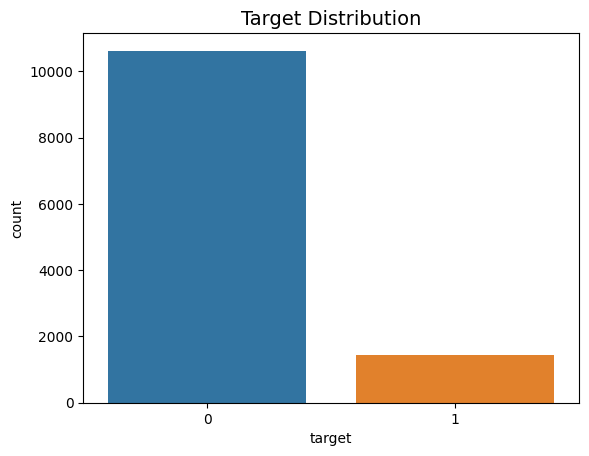

In [13]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

### Distribution of the Gender column

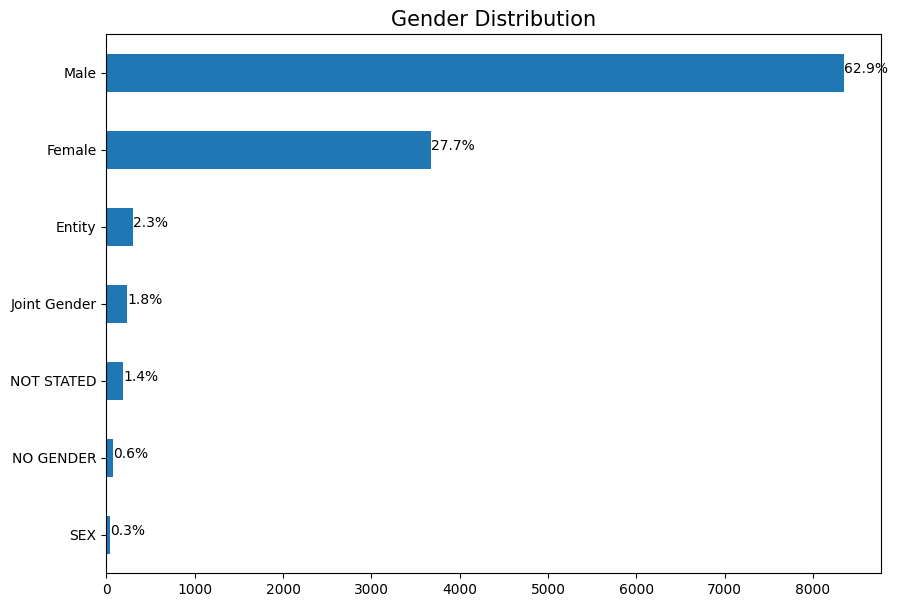

In [14]:
# Gender distribution 
ax = all_data.Gender.value_counts().sort_values().plot(kind = 'barh', figsize=(10,7))
plt.title('Gender Distribution', fontdict={'size': 15})
for p in ax.patches:
  percentage ='{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
  width, height =p.get_width(),p.get_height()
  x=p.get_x()+width+0.02
  y=p.get_y()+height/2
  ax.annotate(percentage,(x,y))

In [15]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      8356
Female    3679
Other      846
Name: Gender, dtype: int64

### Number of unique values per categorical column

In [16]:
# Check unique values for each categorical column
for col in cat_cols:
  print(col)
  print(all_data[col].unique(), '\n')

Gender
['Male', 'Female', 'Other', NaN]
Categories (3, object): ['Other', 'Female', 'Male'] 

Car_Category
['Saloon', 'JEEP', NaN, 'Motorcycle', 'Truck', ..., 'Wagon', 'Shape Of Vehicle Chasis', 'Sedan', 'Station 4 Wheel', 'Tipper Truck']
Length: 17
Categories (16, object): ['Bus', 'CAMRY CAR HIRE', 'JEEP', 'Mini Bus', ..., 'Tipper Truck', 'Truck', 'Van', 'Wagon'] 

Subject_Car_Colour
['Black', 'Grey', 'Red', NaN, 'As Attached', ..., 'Yellow & White', 'Beige Mitalic', 'Light Gray', 'Blue Sky', 'Red Maroon']
Length: 47
Categories (46, object): ['As Attached', 'Ash', 'B.Silver', 'Beige Mitalic', ..., 'White & Yellow', 'Wine', 'Yellow', 'Yellow & White'] 

Subject_Car_Make
['TOYOTA', NaN, 'REXTON', 'Lexus', 'Hyundai', ..., 'BRILLIANCE', 'Buik', 'COMMANDER', 'Bajaj', 'Datsun']
Length: 76
Categories (75, object): ['.', 'ABG', 'ACURA', 'As Attached', ..., 'Volvo', 'Wrangler Jeep', 'Yamaha', 'ZOYTE'] 

LGA_Name
[NaN, 'Lagos', 'Ikeja', 'Badagry', 'Eti-Osa', ..., 'Hong', 'Ifako-Agege', 'Benue',

### Filling in missing values
#### Missing values can be filled using different strategies
Tips:
 - Mean
 - Max
 - Min
 - [sklearn SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
 - Others... do more reasearch

In [17]:
# Categorical data imputationb
#  Imputation using New Category
'''
all_data.isnull().sum()

# Impute with most frequent categories
for col in all_data.columns:
  if col in cat_cols:
    # If no category uknown create if there just continue                     
    all_data[col] = all_data[col].cat.add_categories("Uknown").fillna("Uknown")
    # all_data[col] = all_data[col].fillna("Uknown")
  elif col in date_cols+num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
all_data[all_data.columns.difference(['target'])].isna().sum()
'''


'\nall_data.isnull().sum()\n\n# Impute with most frequent categories\nfor col in all_data.columns:\n  if col in cat_cols:\n    # If no category uknown create if there just continue                     \n    all_data[col] = all_data[col].cat.add_categories("Uknown").fillna("Uknown")\n    # all_data[col] = all_data[col].fillna("Uknown")\n  elif col in date_cols+num_cols:\n    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])\nall_data[all_data.columns.difference([\'target\'])].isna().sum()\n'

In [18]:
# Fill in missing values
# For cat cols and date cols fill in with mode and for num cols fill in with 9999
# for col in all_data.columns:
#   if col in date_cols+cat_cols:
#     all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
#   elif col in num_cols:
#     all_data[col] = all_data[col].fillna(all_data[col].fillna(9999))

# # Confirm that there aren't any missing values
# all_data[all_data.columns.difference(['target'])].isna().sum()


### Feature Engineering
#### Alot of features can be extracted from dates
Tips:
 - Quarter, Start of Year, month?
 - Is it a weekend, weekday?
 - Is it a holiday
 - Duration between different periods, e.g start and end of a policy
 - What features can be derived from the age column
 - Be creative 😉

In [19]:
# Extract date features from the date columns
for col in date_cols:
  for date_feature in ['year', 'month', 'day']:
    all_data[col+date_feature] = getattr(all_data[col].dt, date_feature)

all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,0.0,2010,5,14,2011,5,13,2010,5,14
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,1.0,2010,11,29,2011,11,28,2010,11,29
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,0.0,2010,3,21,2011,3,20,2010,3,21
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,...,0.0,2010,8,21,2011,8,20,2010,8,21
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,NaN,NaN,NaN,...,1.0,2010,8,29,2010,12,31,2010,8,29


<b><u>Duration in Days </u></b>
- Found by differencing policy start and end days
- Unique Values are 311
- Max days taken: 11139
- Min Days takes: 12
- Mode days taken: 364 (People often take yearly claims)
- Mean: 349.2185076424968

In [20]:
all_data.insert(3,"Duration(Days)",0)

In [21]:
all_data["Duration(Days)"] = (all_data['Policy End Date'] - all_data['Policy Start Date']).dt.days
all_data["Duration(Days)"].head()


0    364
1    364
2    364
3    364
4    124
Name: Duration(Days), dtype: int64

In [22]:

all_data.head()

,ID,Policy Start Date,Policy End Date,Duration(Days),Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,...,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday
0,ID_0040R73,2010-05-14,2011-05-13,364,Male,30,2010-05-14,1,Saloon,Black,...,0.0,2010,5,14,2011,5,13,2010,5,14
1,ID_0046BNK,2010-11-29,2011-11-28,364,Female,79,2010-11-29,1,JEEP,Grey,...,1.0,2010,11,29,2011,11,28,2010,11,29
2,ID_005QMC3,2010-03-21,2011-03-20,364,Male,43,2010-03-21,1,Saloon,Red,...,0.0,2010,3,21,2011,3,20,2010,3,21
3,ID_0079OHW,2010-08-21,2011-08-20,364,Male,2,2010-08-21,1,NaN,NaN,...,0.0,2010,8,21,2011,8,20,2010,8,21
4,ID_00BRP63,2010-08-29,2010-12-31,124,Other,20,2010-08-29,3,NaN,NaN,...,1.0,2010,8,29,2010,12,31,2010,8,29


<b><u> Actual Days Of The Week

In [23]:
# Weekday or Weekends
# Add 4 columns: Start_date week day. Start_date holiday. End_date weekday. End_date holiday (1,0)
# Get index to place the new columns for Start Date
start_day_loc = all_data.columns.get_loc("Policy Start Dateday")
all_data.insert(start_day_loc+1,"Policy Start Date Actualday","")


In [24]:
end_day_loc = all_data.columns.get_loc("Policy End Dateday")
all_data.insert(end_day_loc+1,"Policy End Date Actualday","")

In [25]:

# type(all_data['Policy End Date'][0])
# all_data['Policy Start Date'][2].day_name()
for position, day in enumerate(all_data['Policy Start Date']):
    all_data['Policy Start Date Actualday'][position] = day.day_name()
for position, day in enumerate(all_data['Policy End Date']):
    all_data['Policy End Date Actualday'][position] = day.day_name()
all_data.head(). iloc[:, 0:16]



,ID,Policy Start Date,Policy End Date,Duration(Days),Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy Start Dateyear
0,ID_0040R73,2010-05-14,2011-05-13,364,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0.0,2010
1,ID_0046BNK,2010-11-29,2011-11-28,364,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1.0,2010
2,ID_005QMC3,2010-03-21,2011-03-20,364,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0.0,2010
3,ID_0079OHW,2010-08-21,2011-08-20,364,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0.0,2010
4,ID_00BRP63,2010-08-29,2010-12-31,124,Other,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1.0,2010


<b><u> WeekDays and Weekends

In [30]:
start_day_loc = all_data.columns.get_loc("Policy Start Date Actualday")
all_data.insert(start_day_loc+1,"Weekday Start Date","")

In [31]:
end_day_loc = all_data.columns.get_loc("Policy End Date Actualday")
all_data.insert(start_day_loc+1,"Weekday End Date","")

In [32]:
# Weekday(1) and Weekends(0)
weekends = ['Friday','Saturday','Sunday']
for position, day in enumerate(all_data["Policy Start Date Actualday"]):
    if day in weekends:
        all_data["Weekday Start Date"][position] = 1
    else:
        all_data["Weekday Start Date"][position] = 0

for position, day in enumerate(all_data["Policy End Date Actualday"]):
    if day in weekends:
        all_data["Weekday End Date"][position] = 1
    else:
        all_data["Weekday End Date"][position] = 0
 
all_data["Weekday Start Date"]

0        1
1        0
2        1
3        1
4        1
        ..
13276    1
13277    0
13278    0
13279    0
13280    0
Name: Weekday Start Date, Length: 13281, dtype: object

<b><u> Holidays

In [ ]:
start_day_loc = all_data.columns.get_loc("Policy Start Dateday")
all_data.insert(start_day_loc+1, "Policy Start Holiday",0)


In [ ]:

end_day_loc = all_data.columns.get_loc("Policy End Dateday")
all_data.insert(end_day_loc+1, "Policy End Holiday",0)

In [27]:
# Find holidays In the Country
nigeria_holidays = ['1/1','25/2','26/2','2/4','5/4','1/5','31/5','8/9','10/9','1/10','16/11','17/11','25/12','26/12']
# len(nigeria_holidays)
# 14 holidays in nigeria


In [ ]:
all_data.head(). iloc[:, 0:24]


,ID,Policy Start Date,Policy End Date,Duration(Days),Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,...,ProductName,Policy End Date Actualday,target,Policy Start Dateyear,Policy Start Datemonth,YearQuarters Policy Start,,Policy Start Dateday,Policy Start Holiday,Policy End Dateyear
0,ID_0040R73,2010-05-14,2011-05-13,364,Male,30,2010-05-14,1,Saloon,Black,...,Car Classic,Friday,0.0,2010,5,2,0,14,0,2011
1,ID_0046BNK,2010-11-29,2011-11-28,364,Female,79,2010-11-29,1,JEEP,Grey,...,Car Classic,Monday,1.0,2010,11,4,0,29,0,2011
2,ID_005QMC3,2010-03-21,2011-03-20,364,Male,43,2010-03-21,1,Saloon,Red,...,Car Classic,Sunday,0.0,2010,3,1,0,21,0,2011
3,ID_0079OHW,2010-08-21,2011-08-20,364,Male,2,2010-08-21,1,NaN,NaN,...,CarSafe,Saturday,0.0,2010,8,3,0,21,0,2011
4,ID_00BRP63,2010-08-29,2010-12-31,124,Other,20,2010-08-29,3,NaN,NaN,...,Muuve,Friday,1.0,2010,8,3,0,29,0,2010


<b><u> Quarter of the Year

In [ ]:

start_month_loc = all_data.columns.get_loc("Policy Start Datemonth")
all_data.insert(start_month_loc+1, "YearQuarters Policy Start",0)

In [ ]:
end_month_loc = all_data.columns.get_loc("Policy End Datemonth")
all_data.insert(end_month_loc+1, "YearQuarters Policy End",0)

In [ ]:
# Quarter Year(1,4,8,12), Start of Year and End of year
# 1. Add Quarter of Year columns
# 2. Has 4 Categories: switch
quarter_start_policy = all_data["YearQuarters Policy Start"]
month_policy_start = all_data["Policy Start Datemonth"]
for position, month in enumerate(month_policy_start):
    if month <= 3:
        quarter_start_policy[position] = 1
    elif month > 3 and month <= 6:
        quarter_start_policy[position] = 2
    elif month > 6 and month <= 9:
        quarter_start_policy[position] = 3
    else:
        quarter_start_policy[position] = 4
quarter_start_policy

0        2
1        4
2        1
3        3
4        3
        ..
13276    4
13277    1
13278    3
13279    1
13280    1
Name: YearQuarters Policy Start, Length: 13281, dtype: int64

In [ ]:
#Policy End Quarter
quarter_end_policy = all_data["YearQuarters Policy End"]
month_policy_start = all_data["Policy End Datemonth"]
for position, month in enumerate(month_policy_start):
    if month <= 3:
        quarter_end_policy[position] = 1
    elif month > 3 and month <= 6:
        quarter_end_policy[position] = 2
    elif month > 6 and month <= 9:
        quarter_end_policy[position] = 3
    else:
        quarter_end_policy[position] = 4
quarter_end_policy

0        2
1        4
2        1
3        3
4        4
        ..
13276    4
13277    1
13278    3
13279    1
13280    1
Name: YearQuarters Policy End, Length: 13281, dtype: int64

#### Try different strategies of dealing with categorical variables
Tips:
 - One hot encoding
 - Label encoding
 - Target encoding
 - Reduce the number of unique values...

In [ ]:
# Encode categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols)
all_data.head()

,ID,Policy Start Date,Policy End Date,Duration(Days),Age,First Transaction Date,No_Pol,Policy Start Date Actualday,Policy End Date Actualday,target,...,State_Warri-South,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
0,ID_0040R73,2010-05-14,2011-05-13,364,30,2010-05-14,1,Friday,Friday,0.0,...,0,0,1,0,0,0,0,0,0,0
1,ID_0046BNK,2010-11-29,2011-11-28,364,79,2010-11-29,1,Monday,Monday,1.0,...,0,0,1,0,0,0,0,0,0,0
2,ID_005QMC3,2010-03-21,2011-03-20,364,43,2010-03-21,1,Sunday,Sunday,0.0,...,0,0,1,0,0,0,0,0,0,0
3,ID_0079OHW,2010-08-21,2011-08-20,364,2,2010-08-21,1,Saturday,Saturday,0.0,...,0,0,0,0,0,0,1,0,0,0
4,ID_00BRP63,2010-08-29,2010-12-31,124,20,2010-08-29,3,Sunday,Friday,1.0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Change columns names ([LightGBM] Do not support special JSON characters in feature name.)
import re
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in all_data.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
all_data_renamed = all_data.rename(columns=new_names)
np.unique(all_data_renamed.dtypes)

array([dtype('uint8'), dtype('<M8[ns]'), dtype('uint8'), dtype('int64'),
       dtype('float64'), dtype('O')], dtype=object)

In [ ]:
# View the columns with 'datetime' data types
columns_to_drop = all_data_renamed.select_dtypes(include=['datetime64'])
columns_to_drop

,PolicyStartDate,PolicyEndDate,FirstTransactionDate
0,2010-05-14,2011-05-13,2010-05-14
1,2010-11-29,2011-11-28,2010-11-29
2,2010-03-21,2011-03-20,2010-03-21
3,2010-08-21,2011-08-20,2010-08-21
4,2010-08-29,2010-12-31,2010-08-29
...,...,...,...
13276,2010-12-05,2011-12-04,2010-12-05
13277,2010-01-14,2011-01-13,2010-01-14
13278,2010-07-26,2011-07-25,2010-07-26
13279,2010-02-16,2011-02-15,2010-02-16


In [ ]:
# Exclude the data columns due to their data types
# Separate train and test data from the combined dataframe
train_df = all_data_renamed[:ntrain].drop(columns=columns_to_drop)
test_df = all_data_renamed[ntrain:].drop(columns=columns_to_drop)

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((12079, 549), (1202, 549))

### Training and making predictions
Tips:
- Is lgbm the best model for this challenge?
- Parameter tuning
 - Grid search, random search, perhaps bayesian search works better...



In [ ]:
# Select main columns to be used in training
main_cols = train_df.columns.difference(['ID', 'target'])

X = train_df[main_cols]
y = train_df.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# Train model
model = LGBMClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: PolicyEndDateActualday, PolicyStartDateActualday

#### [More on F1 Score](https://en.wikipedia.org/wiki/F-score)

### Making predictions of the test set and creating a submission file

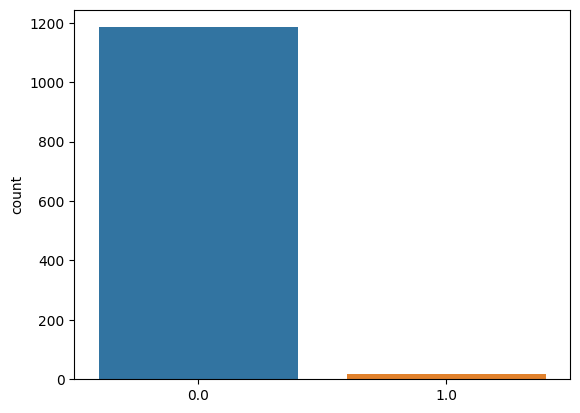

In [ ]:
# Make prediction on the test set
test_df = test_df[main_cols]
predictions = model.predict(test_df)

# Create a submission file
sub_file = ss.copy()
sub_file.predictions = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.predictions);

In [ ]:
# Create a csv file and upload to zindi 
sub_file.to_csv('Baseline.csv', index = False)

###More Tips
- Thorough EDA and domain knowledge sourcing
- Re-group Categorical features 
- More Feature Engineering 
- Dataset balancing - oversampling, undersampling, SMOTE...
- Ensembling of models 
- Cross-validation: Group folds, Stratified...

# ******************* GOOD LUCK!!! ***************************